In [1]:
import tensorflow as tf
import numpy as np
import re
import collections
import sklearn.metrics as sk 

In [2]:
def load_data(filename='./data/imdb.train'):
    '''
    :param filename: the system location of the data to load
    :return: the text (x) and its label (y)
             the text is a list of words and is not processed
    '''

    # stop words taken from nltk
    stop_words = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours',
                  'yourself','yourselves','he','him','his','himself','she','her','hers','herself',
                  'it','its','itself','they','them','their','theirs','themselves','what','which',
                  'who','whom','this','that','these','those','am','is','are','was','were','be',
                  'been','being','have','has','had','having','do','does','did','doing','a','an',
                  'the','and','but','if','or','because','as','until','while','of','at','by','for',
                  'with','about','against','between','into','through','during','before','after',
                  'above','below','to','from','up','down','in','out','on','off','over','under',
                  'again','further','then','once','here','there','when','where','why','how','all',
                  'any','both','each','few','more','most','other','some','such','no','nor','not',
                  'only','own','same','so','than','too','very','s','t','can','will','just','don',
                  'should','now','d','ll','m','o','re','ve','y','ain','aren','couldn','didn',
                  'doesn','hadn','hasn','haven','isn','ma','mightn','mustn','needn','shan',
                  'shouldn','wasn','weren','won','wouldn']

    x, y = [], []
    with open(filename, "r") as f:
        for line in f:
            line = re.sub(r'\W+', ' ', line).strip().lower()  # perhaps don't make words lowercase?
            x.append(line[:-1])
            x[-1] = ' '.join(word for word in x[-1].split() if word not in stop_words)
            y.append(line[-1])
    return x, np.array(y, dtype=int)

In [3]:
def get_vocab(dataset):
    '''
    :param dataset: the text from load_data

    :return: a _ordered_ dictionary from words to counts
    '''
    vocab = {}

    # create a counter for each word
    for example in dataset:
        example_as_list = example.split()
        for word in example_as_list:
            vocab[word] = 0

    for example in dataset:
        example_as_list = example.split()
        for word in example_as_list:
            vocab[word] += 1
    
    # sort from greatest to least by count
    return collections.OrderedDict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))

In [4]:
def text_to_rank(dataset, _vocab, desired_vocab_size=5000):
    '''
    :param dataset: the text from load_data
    :vocab: a _ordered_ dictionary of vocab words and counts from get_vocab
    :param desired_vocab_size: the desired vocabulary size
    words no longer in vocab become UUUNNNKKK
    :return: the text corpus with words mapped to their vocab rank,
    with all sufficiently infrequent words mapped to UUUNNNKKK; UUUNNNKKK has rank desired_vocab_size
    (the infrequent word cutoff is determined by desired_vocab size)
    '''
    _dataset = dataset[:]     # aliasing safeguard
    vocab_ordered = list(_vocab)
    count_cutoff = _vocab[vocab_ordered[desired_vocab_size-1]] # get word by its rank and map to its count
    
    word_to_rank = {}
    for i in range(len(vocab_ordered)):
        # we add one to make room for any future padding symbol with value 0
        word_to_rank[vocab_ordered[i]] = i + 1
    
    # we need to ensure that other words below the word on the edge of our desired_vocab size
    # are not also on the count cutoff, so we subtract a bit
    # this is likely quicker than adding another preventative if case
    for i in range(50):
        _vocab[vocab_ordered[desired_vocab_size+i]] -= 0.1
    
    for i in range(len(_dataset)):
        example = _dataset[i]
        example_as_list = example.split()
        for j in range(len(example_as_list)):
            try:
                if _vocab[example_as_list[j]] >= count_cutoff:
                    example_as_list[j] = word_to_rank[example_as_list[j]] 
                else:
                    example_as_list[j] = desired_vocab_size  # UUUNNNKKK
            except:
                example_as_list[j] = desired_vocab_size  # UUUNNNKKK
        _dataset[i] = example_as_list

    return _dataset

In [5]:
# taken from keras
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    '''Pads each sequence to the same length:
    the length of the longest sequence.
    If maxlen is provided, any sequence longer
    than maxlen is truncated to maxlen.
    Truncation happens off either the beginning (default) or
    the end of the sequence.
    Supports post-padding and pre-padding (default).
    # Arguments
        sequences: list of lists where each element is a sequence
        maxlen: int, maximum length
        dtype: type to cast the resulting sequence.
        padding: 'pre' or 'post', pad either before or after each sequence.
        truncating: 'pre' or 'post', remove values from sequences larger than
            maxlen either in the beginning or in the end of the sequence
        value: float, value to pad the sequences to the desired value.
    # Returns
        x: numpy array with dimensions (number_of_sequences, maxlen)
    '''
    lengths = [len(s) for s in sequences]

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

In [9]:
max_example_len = 400
batch_size = 32
embedding_dims = 50
vocab_size = 5000
num_epochs = 15

print('Loading Data')
X_train, Y_train = load_data()
X_dev, Y_dev = load_data('./data/imdb.dev')
X_test, Y_test = load_data('./data/imdb.test')

vocab = get_vocab(X_train)
X_train = text_to_rank(X_train, vocab, 5000)
X_dev = text_to_rank(X_dev, vocab, 5000)
X_test = text_to_rank(X_test, vocab, 5000)

X_train = pad_sequences(X_train, maxlen=max_example_len)
X_dev = pad_sequences(X_dev, maxlen=max_example_len)
X_test = pad_sequences(X_test, maxlen=max_example_len)
print('Data loaded')

num_examples = Y_train.shape[0]
num_batches = num_examples//batch_size

Loading Data
Data loaded


In [14]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(dtype=tf.int32, shape=[None, max_example_len])
    y = tf.placeholder(dtype=tf.int64, shape=[None])
#     is_training = tf.placeholder(tf.bool)
    
    # add one to vocab size for the padding symbol
    W_embedding = tf.Variable(tf.nn.l2_normalize(
        tf.random_normal([vocab_size+1, embedding_dims]), 0), trainable=True)
    
    w_vecs = tf.nn.embedding_lookup(W_embedding, x)
    pooled = tf.reduce_mean(w_vecs, reduction_indices=[1])
    
    W_out = tf.Variable(tf.nn.l2_normalize(tf.random_normal([embedding_dims, 2]), 0))
    b_out = tf.Variable(tf.zeros([2]))
    
    logits = tf.matmul(pooled, W_out) + b_out
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y))

    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

    acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(logits, 1), y)))

In [15]:
# initialize
sess = tf.InteractiveSession(graph=graph)
tf.initialize_all_variables().run()
# create saver to train model
saver = tf.train.Saver(max_to_keep=1)

print('Initialized')

Initialized


In [13]:
sess.close()

In [16]:
best_acc = 0

for epoch in range(num_epochs):
    # shuffle data every epoch
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    X_train = X_train[indices]
    Y_train = Y_train[indices]

    for i in range(num_batches):
        offset = i * batch_size

        x_batch = X_train[offset:offset + batch_size]
        y_batch = Y_train[offset:offset + batch_size]

        _, l, batch_acc = sess.run([optimizer, loss, acc], feed_dict={x: x_batch, y: y_batch})

        if i % 100 == 0:
            curr_dev_acc = sess.run(
                acc, feed_dict={x: X_dev, y: Y_dev})
            if best_acc < curr_dev_acc:
                best_acc = curr_dev_acc
                saver.save(sess, './data/best_imdb_model.ckpt')

    print('Epoch %d | Minibatch loss %.3f | Minibatch accuracy %.3f | Dev accuracy %.3f' %
          (epoch+1, l, batch_acc, curr_dev_acc))


Epoch 1 | Minibatch loss 0.529 | Minibatch accuracy 68.750 | Dev accuracy 59.560
Epoch 2 | Minibatch loss 0.251 | Minibatch accuracy 90.625 | Dev accuracy 87.000
Epoch 3 | Minibatch loss 0.301 | Minibatch accuracy 84.375 | Dev accuracy 86.800
Epoch 4 | Minibatch loss 0.175 | Minibatch accuracy 96.875 | Dev accuracy 84.840
Epoch 5 | Minibatch loss 0.371 | Minibatch accuracy 84.375 | Dev accuracy 85.740
Epoch 6 | Minibatch loss 0.234 | Minibatch accuracy 84.375 | Dev accuracy 85.540
Epoch 7 | Minibatch loss 0.248 | Minibatch accuracy 90.625 | Dev accuracy 88.840
Epoch 8 | Minibatch loss 0.277 | Minibatch accuracy 87.500 | Dev accuracy 83.520
Epoch 9 | Minibatch loss 0.293 | Minibatch accuracy 87.500 | Dev accuracy 89.260
Epoch 10 | Minibatch loss 0.225 | Minibatch accuracy 93.750 | Dev accuracy 88.880
Epoch 11 | Minibatch loss 0.252 | Minibatch accuracy 84.375 | Dev accuracy 85.760
Epoch 12 | Minibatch loss 0.215 | Minibatch accuracy 93.750 | Dev accuracy 87.980
Epoch 13 | Minibatch loss

In [17]:
# restore variables from disk
saver.restore(sess, "./data/best_imdb_model.ckpt")
print("Best model restored!")

print('Dev accuracy:', sess.run(acc, feed_dict={x: X_dev, y: Y_dev}))

Best model restored!
Dev accuracy: 89.26


In [18]:
s = tf.nn.softmax(logits)
s_prob = tf.reduce_max(s, reduction_indices=[1], keep_dims=True)
kl_all = tf.log(2.) + tf.reduce_sum(s * tf.log(tf.abs(s) + 1e-10), reduction_indices=[1], keep_dims=True)
m_all, v_all = tf.nn.moments(kl_all, axes=[0])

logits_right = tf.boolean_mask(logits, tf.equal(tf.argmax(logits, 1), y))
s_right = tf.nn.softmax(logits_right)
s_right_prob = tf.reduce_max(s_right, reduction_indices=[1], keep_dims=True)
kl_right = tf.log(2.) + tf.reduce_sum(s_right * tf.log(tf.abs(s_right) + 1e-10), reduction_indices=[1], keep_dims=True)
m_right, v_right = tf.nn.moments(kl_right, axes=[0])

logits_wrong = tf.boolean_mask(logits, tf.not_equal(tf.argmax(logits, 1), y))
s_wrong = tf.nn.softmax(logits_wrong)
s_wrong_prob = tf.reduce_max(s_wrong, reduction_indices=[1], keep_dims=True)
kl_wrong = tf.log(2.) + tf.reduce_sum(s_wrong * tf.log(tf.abs(s_wrong) + 1e-10), reduction_indices=[1], keep_dims=True)
m_wrong, v_wrong = tf.nn.moments(kl_wrong, axes=[0])

In [162]:
print('BEGIN DEV STATS')
err, scores, kl_a, kl_r, kl_w, s_p, s_rp, s_wp = sess.run(
    [100 - acc, s, kl_all, kl_right, kl_wrong, s_prob, s_right_prob, s_wrong_prob],
    feed_dict={x: X_dev, y: Y_dev})

print('IMDB Error (%)| Prediction Prob (mean, std) | PProb Right (mean, std) | PProb Wrong (mean, std):')
print(err, '|', np.mean(s_p), np.std(s_p), '|', np.mean(s_rp), np.std(s_rp), '|', np.mean(s_wp), np.std(s_wp))

safe, risky = kl_r, kl_w
labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
labels[:safe.shape[0]] += 1
examples = np.squeeze(np.vstack((safe, risky)))

print('\nKL[p||u]: Right/Wrong classification distinction')
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

# safe, risky = s_rp, s_wp
# labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
# labels[:safe.shape[0]] += 1
# examples = np.squeeze(np.vstack((safe, risky)))
# print('\nPrediction Prob: Right/Wrong classification distinction')
# print('AUPR', sk.average_precision_score(labels, examples))
# print('AUROC', sk.roc_auc_score(labels, examples))
print('END DEV STATS')

BEGIN DEV STATS
IMDB Error (%)| Prediction Prob (mean, std) | PProb Right (mean, std) | PProb Wrong (mean, std):
10.74 | 0.884663 0.137912 | 0.901951 0.125093 | 0.740977 0.154629

KL[p||u]: Right/Wrong classification distinction
AUPR 0.966338843302
AUROC 0.795715318712
END DEV STATS


In [163]:
fpr, tpr, taus = sk.roc_curve(labels, examples)

In [164]:
preds = np.argmax(scores, axis=1)

In [150]:
preds.shape

(5000,)

In [165]:
np.mean(preds != Y_dev)

0.1074

In [161]:
np.max(kl_a)

0.69314718

In [166]:
tau_star = -1e5
tau_idx = -1
J_stat = -1e-5

for i in range(fpr.shape[0]):
    curr_J = tpr[i] + (1 - fpr[i]) - 1
    if curr_J > J_stat:
        J_stat = curr_J
        tau_star = taus[i]
        tau_idx = i

In [171]:
tau_star

0.32833761

In [175]:
preds_prime = preds.copy()
preds_prime[(kl_a < 0.1).reshape((-1,))] = 1 - preds[(kl_a < 0.1).reshape((-1,))]

np.mean(preds_prime != Y_dev)

0.16120000000000001

In [178]:
(kl_a < 0.1).reshape((-1,)).sum()/5000

0.159

In [114]:
min_err = 100
best_t = 1e5
for t in taus:
    v = np.mean((s_p > t).astype(np.int).reshape((-1)) != Y_dev)
    if v < min_err:
        min_err = v
        best_t = t
print(min_err, best_t)

0.4806 0.664964


In [172]:
np.mean((kl_a > tau_star).astype(np.int).reshape((-1)) != Y_dev)

0.49740000000000001

In [41]:
print(tau_star, tau_idx)

0.881059 298


In [107]:
min_err = 100
for t in range(0,100):
    v = np.mean((scores[:,1] > t/100).astype(np.int).reshape((-1,)) != Y_dev)
    if v < min_err:
        min_err = v

In [108]:
100*np.mean((scores[:,1] > tau_star).astype(np.int).reshape((-1)) != Y_dev)

20.119999999999997

In [63]:
s_p

array([[ 0.98233402],
       [ 0.72248143],
       [ 0.87506396],
       ..., 
       [ 0.91968423],
       [ 0.69464648],
       [ 0.61481184]], dtype=float32)

In [54]:
Y_dev

array([1, 0, 1, ..., 0, 1, 0])

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

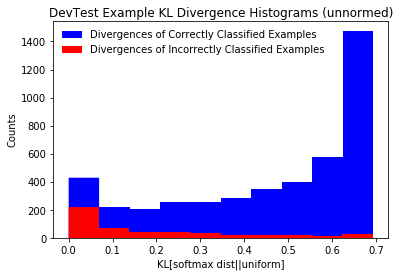

In [192]:
plt.hist(kl_r, color='blue')
plt.hist(kl_w, color='red')
plt.title('DevTest Example KL Divergence Histograms (unnormed)')
plt.xlabel('KL[softmax dist||uniform]')
plt.ylabel('Counts')
plt.legend(['Divergences of Correctly Classified Examples', 'Divergences of Incorrectly Classified Examples'])
plt.show()

In [19]:
err, kl_a, kl_r, kl_w, s_p, s_rp, s_wp = sess.run(
    [100 - acc, kl_all, kl_right, kl_wrong, s_prob, s_right_prob, s_wrong_prob],
    feed_dict={x: X_test, y: Y_test})

print('IMDB Error (%)| Prediction Prob (mean, std) | PProb Right (mean, std) | PProb Wrong (mean, std):')
print(err, '|', np.mean(s_p), np.std(s_p), '|', np.mean(s_rp), np.std(s_rp), '|', np.mean(s_wp), np.std(s_wp))

safe, risky = kl_r, kl_w
labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
labels[:safe.shape[0]] += 1
examples = np.squeeze(np.vstack((safe, risky)))

print('\nKL[p||u]: Right/Wrong classification distinction')
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

safe, risky = s_rp, s_wp
labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
labels[:safe.shape[0]] += 1
examples = np.squeeze(np.vstack((safe, risky)))
print('\nPrediction Prob: Right/Wrong classification distinction')
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))


IMDB Error (%)| Prediction Prob (mean, std) | PProb Right (mean, std) | PProb Wrong (mean, std):
11.84 | 0.878831 0.13987 | 0.89978 0.124596 | 0.722847 0.148468

KL[p||u]: Right/Wrong classification distinction
AUPR 0.968489887534
AUROC 0.821134991048

Prediction Prob: Right/Wrong classification distinction
AUPR 0.968489843164
AUROC 0.821134968056


In [13]:
cr_data, cr_labels = load_data('./data/CR.test')
cr_data = text_to_rank(cr_data, vocab, 5000)
cr_data = pad_sequences(cr_data, maxlen=max_example_len)

In [14]:
kl_oos, s_p_oos = sess.run([kl_all, s_prob], feed_dict={x: cr_data})

print('Customer Reviews (out of sample) Prediction Probability (mean, std):')
print(np.mean(s_p_oos), np.std(s_p_oos))

print('\nKL[p||u]: In/out distribution distinction')
in_sample, oos = kl_a, kl_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nPrediction Prob: In/out distribution distinction')
in_sample, oos = s_p, s_p_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nKL[p||u]: In/out distribution distinction (relative to correct examples)')
in_sample, oos = kl_r, kl_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nPrediction Prob: In/out distribution distinction (relative to correct examples)')
in_sample, oos = s_rp, s_p_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

Customer Reviews (out of sample) Prediction Probability (mean, std):
0.6191 0.0908484

KL[p||u]: In/out distribution distinction
AUPR 0.998346269866
AUROC 0.92270688

Prediction Prob: In/out distribution distinction
AUPR 0.99834626832
AUROC 0.9227068

KL[p||u]: In/out distribution distinction (relative to correct examples)
AUPR 0.998743855974
AUROC 0.947301487933

Prediction Prob: In/out distribution distinction (relative to correct examples)
AUPR 0.998743855974
AUROC 0.947301487933


In [15]:
rt_data, rt_labels = load_data('./data/MR.test')
rt_data = text_to_rank(rt_data, vocab, 5000)
rt_data = pad_sequences(rt_data, maxlen=max_example_len)

In [16]:
kl_oos, s_p_oos = sess.run([kl_all, s_prob], feed_dict={x: rt_data})

print('Rotten Tomatoes (out of sample) Prediction Probability (mean, std):')
print(np.mean(s_p_oos), np.std(s_p_oos))

print('\nKL[p||u]: In/out distribution distinction')
in_sample, oos = kl_a, kl_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nPrediction Prob: In/out distribution distinction')
in_sample, oos = s_p, s_p_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nKL[p||u]: In/out distribution distinction (relative to correct examples)')
in_sample, oos = kl_r, kl_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

print('\nPrediction Prob: In/out distribution distinction (relative to correct examples)')
in_sample, oos = s_rp, s_p_oos
labels = np.zeros((in_sample.shape[0] + oos.shape[0]), dtype=np.int32)
labels[:in_sample.shape[0]] += 1
examples = np.squeeze(np.vstack((in_sample, oos)))
print('AUPR', sk.average_precision_score(labels, examples))
print('AUROC', sk.roc_auc_score(labels, examples))

Rotten Tomatoes (out of sample) Prediction Probability (mean, std):
0.630085 0.0969686

KL[p||u]: In/out distribution distinction
AUPR 0.996352671834
AUROC 0.9144708

Prediction Prob: In/out distribution distinction
AUPR 0.996352668118
AUROC 0.9144707

KL[p||u]: In/out distribution distinction (relative to correct examples)
AUPR 0.997195570054
AUROC 0.940886703865

Prediction Prob: In/out distribution distinction (relative to correct examples)
AUPR 0.997195568168
AUROC 0.940886658501
